In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom
from tqdm import trange
from scipy.stats import binned_statistic
from cn_tools.data_processing import prepare_df
import os

$\Large{\text{Load Data}}$

In [6]:
keys = ['005', '006', '007', '008']
VF = {key:pd.read_csv(f'../Data/VF_{key}_og.csv', index_col = 0) for key in keys}

$\Large{\text{Correspondence to Song et al.}}$

In [3]:
n_bins = 40
z_phi_binned= {}
density = {}
density_binned = {}

for key in keys:
    df = VF[key]
    bin_means, bin_edges, binnumber = binned_statistic(df.lpf, df.contact_number, bins = n_bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2
    z_phi_binned[key] = bin_centers, bin_means
    
    density[key] = np.histogram(df.contact_number, bins = range(1,12), density = True)
    density_binned[key] = np.histogram(df.lpf, bins = n_bins, density = False)

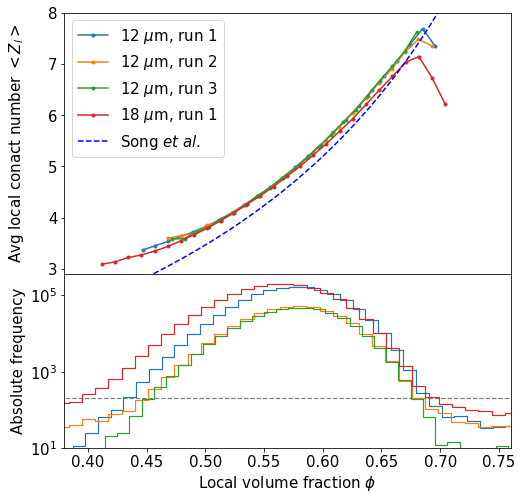

<Figure size 432x288 with 0 Axes>

In [59]:
res_dict = {'005': '12 $\\mu$m, run 1',
 '006': '12 $\\mu$m, run 2',
 '007': '12 $\\mu$m, run 3',
 '008': '18 $\\mu$m, run 1',
 '012': '18 $\\mu$m, run 2',}
 
plt.rcParams.update({'font.size': 15})
fig, (ax1, ax2) = plt.subplots(2,1, figsize = (8,8), sharex = True, 
                               gridspec_kw={'hspace': 0.0, 'height_ratios': [3,2]})

N_limit = 200
for key in keys:
    mask = density_binned[key][0] > N_limit
    bin_centers, bin_means = z_phi_binned[key]
    ax1.plot(bin_centers[mask], bin_means[mask], label = res_dict[key], marker = '.')
    ax2.step(density_binned[key][1][:-1], density_binned[key][0], label = key, linewidth = 1.2)
    
def makse(x):
    return 2*np.sqrt(3)*x/(1-x)

x = np.linspace(0.45, 0.7, 50)
ax1.plot(x, makse(x), 'b--', label = 'Song $\it{et}$ $\it{al.}$')
ax1.legend()
ax1.set_ylabel('Avg local conact number $<Z_l>$')
ax1.set_ylim(2.9,8)

ax2.set_yscale('log')
ax2.set_ylim(bottom = 10)
ax2.set_xlabel('Local volume fraction $\phi$')
ax2.set_ylabel('Absolute frequency')
ax2.hlines(N_limit, 0.3, 0.8, colors= 'Black', linestyles='--', linewidth = 1.2, alpha = 0.5, label =  f'N = {N_limit}')

fig.align_ylabels()
plt.xlim(0.38, 0.76)
plt.savefig('contact_distribution.pdf')

$\Large{\text{Mean Contact Number per Nearest Neighbors}}$

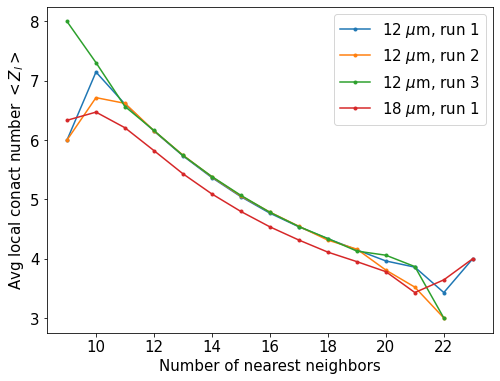

In [5]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})

for key in keys:
    df = VF[key]
    nn = np.sort(df.nn.unique())
    cn = np.array([df.loc[df.nn == n, 'contact_number'].mean() for n in nn])
    plt.plot(nn, cn, '.-', label = res_dict[key])
plt.legend()
plt.xlabel('Number of nearest neighbors')
plt.ylabel('Avg local conact number $<Z_l>$')
plt.savefig('cnpernn.pdf')

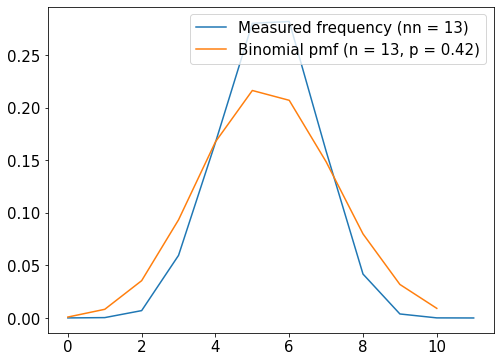

In [7]:
from scipy.stats import binom
n = 13
p = df.loc[df.nn == n, 'contact_number'].mean()/n
cn = np.sort(df.contact_number.unique())
df_nn = df.loc[df.nn == n]
bins = np.sort(df_nn.contact_number.unique())
plt.figure(figsize = (8,6))
plt.plot(np.array([df_nn.loc[df.contact_number == z].shape[0] for z in cn])/df_nn.shape[0], label = f'Measured frequency (nn = {n})')
#df.loc[df.nn == n, 'contact_number'].plot.hist(bins = bins, density = True)
rv = binom(n, p)
plt.plot(rv.pmf(bins), label = f'Binomial pmf ({n = }, {p = :.2f})')
plt.legend()

/tmp/ipykernel_5604/2910566734.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


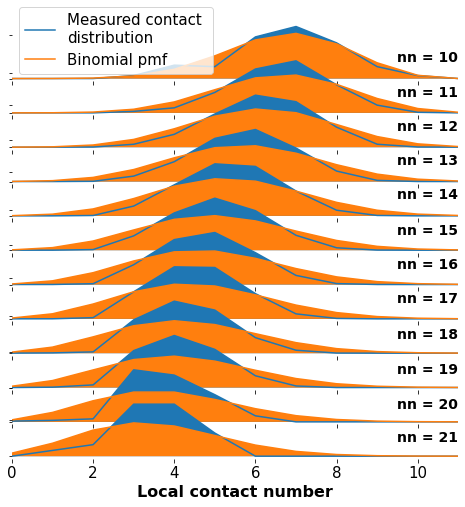

In [12]:
import matplotlib.gridspec as grid_spec
plt.rcParams.update({'font.size': 15})

df = VF['006']
nn = np.unique(df.nn)[1:-1]
cn = np.unique(df.contact_number)

gs = grid_spec.GridSpec(len(nn),1)
fig = plt.figure(figsize=(8,8))

alpha = 0.5

ax_objs = []
for i,n in enumerate(nn):
    p = df.loc[df.nn == n, 'contact_number'].mean()/n
    df_nn = df.loc[df.nn == n]
    #bins = np.unique(df_nn.contact_number)

    ax_objs.append(fig.add_subplot(gs[i:i+1, 0:]))
    ax_objs[-1].set_xlim(cn.min(), cn.max())
    #ax_objs[-1].set_ylim()

    data = np.array([df_nn.loc[df.contact_number == z].shape[0] for z in cn])/df_nn.shape[0]
    ax_objs[-1].plot(cn, data, label = 'Measured contact \ndistribution')
    ax_objs[-1].fill_between(cn, data, alpha=1)

    rv = binom(n, p)
    ax_objs[-1].plot(cn, rv.pmf(cn), label = f'Binomial pmf')
    ax_objs[-1].fill_between(cn, rv.pmf(cn), alpha=1)

    rect = ax_objs[-1].patch
    rect.set_alpha(0)
    ax_objs[-1].set_yticklabels([])

    if i == len(nn)-1:
        ax_objs[-1].set_xlabel("Local contact number",fontweight="bold")
    elif i == 0:
        ax_objs[-1].legend()
        ax_objs[-1].set_xticklabels([])
    else:
        ax_objs[-1].set_xticklabels([])


    spines = ["top","right","left","bottom"]
    for s in spines:
        ax_objs[-1].spines[s].set_visible(False)
    ax_objs[-1].text(11,0.1,f'nn = {n:.0f}',fontweight="bold",ha="right")
gs.update(hspace=-0.4)
plt.tight_layout()
plt.savefig('binomial.pdf')

$\Large{\text{Principal Component Analysis}}$

In [14]:
from cn_tools.data_processing import feature_lists, features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

if 'w000' in features:
    features.remove('w000')
if 'w300' in features:
    features.remove('w300')

df = VF['006']
scaler = StandardScaler()
df_x = pd.DataFrame(scaler.fit_transform(df[features]), columns = features)
df_y = df.contact_number

pca = PCA(n_components=len(features))
pca.fit(df_x)

In [108]:
from lmfit.models import ExponentialModel
model = ExponentialModel()

y_data = np.log(1-np.cumsum(pca.explained_variance_ratio_))
y_data = 1-np.cumsum(pca.explained_variance_ratio_)
#y_data = np.append(1, y_data)
x_data = np.arange(1,len(y_data)+1)

pars = model.guess(data = y_data, x = x_data)
res = model.fit(y_data, pars, x=x_data, nan_policy= 'omit')
print(res.best_values)

{'amplitude': 1.0988608429203988, 'decay': 5.2231227730090986}


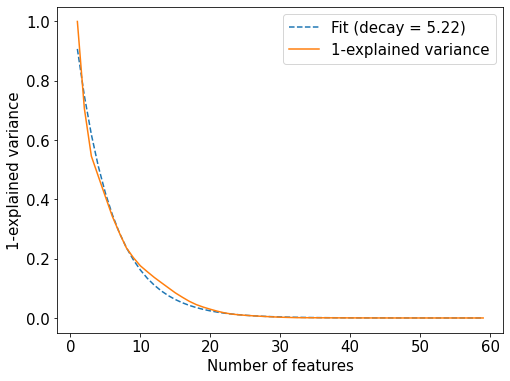

In [107]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size': 15})

decay = res.best_values['decay']
plt.plot(x_data, res.best_fit, label = f'Fit ({decay = :.2f})', linestyle = '--')
plt.plot(x_data, y_data, label = '1-explained variance')
plt.xlabel('Number of features')
plt.ylabel('1-explained variance')
#plt.yscale('log')
plt.legend()
plt.show()

In [58]:
y_data

array([ -0.34744454,  -0.60552004,  -0.73947516,  -0.89269882,
        -1.07124979,  -1.2471452 ,  -1.44106173,  -1.59160366,
        -1.73715701,  -1.85822819,  -1.99078475,  -2.12758625,
        -2.2839638 ,  -2.46898311,  -2.65872013,  -2.87934691,
        -3.10080515,  -3.30815665,  -3.52583819,  -3.77888521,
        -4.05563645,  -4.31434774,  -4.52276116,  -4.71719345,
        -4.89949039,  -5.10793628,  -5.33121461,  -5.61804546,
        -5.95421917,  -6.24230475,  -6.61442159,  -6.92488707,
        -7.10344668,  -7.28527843,  -7.47241543,  -7.64552383,
        -7.82696813,  -8.04325572,  -8.27955653,  -8.48077564,
        -8.73122675,  -9.04903958,  -9.45356486,  -9.99691001,
       -10.77047897, -11.1795427 , -11.53374672, -11.83389707,
       -12.16691884, -12.42682394, -12.72457216, -13.02226058,
       -13.44368852, -14.06032954, -15.11848643,          nan,
                nan,          nan])

In [ ]:
plt.figure(figsize = (12,8))
plt.scatter(near, cont, s = 1000*np.array(size)/np.array(size).max(), c = size, alpha = 0.8, cmap = 'cividis')
plt.colorbar()